In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import numpy as np
from fsd_path_planning.utils.math_utils import unit_2d_vector_from_angle, rotate
from fsd_path_planning.utils.cone_types import ConeTypes

In [38]:
phi_inner = np.arange(0, np.pi / 2, np.pi / 15)
phi_outer = np.arange(0, np.pi / 2, np.pi / 20)

points_inner = unit_2d_vector_from_angle(phi_inner) * 9
points_outer = unit_2d_vector_from_angle(phi_outer) * 12

center = np.mean((points_inner[:2] + points_outer[:2]) / 2, axis=0)
points_inner -= center
points_outer -= center

rotated_points_inner = rotate(points_inner, -np.pi / 2)
rotated_points_outer = rotate(points_outer, -np.pi / 2)
cones_left_raw = rotated_points_inner
cones_right_raw = rotated_points_outer

car_position = np.array([0.0, 0.0])
car_direction = np.array([1.0, 0.0])

In [82]:
idx_unknown = [3]

mask_is_left = np.ones(len(cones_left_raw), dtype=bool)
mask_is_left[:] = False

mask_is_right = np.ones(len(cones_right_raw), dtype=bool)
mask_is_right[:] = False

cones_left = cones_left_raw[mask_is_left]
cones_right = cones_right_raw[mask_is_right]
cones_unknown = np.row_stack([cones_left_raw[~mask_is_left], cones_right_raw[~mask_is_right]])

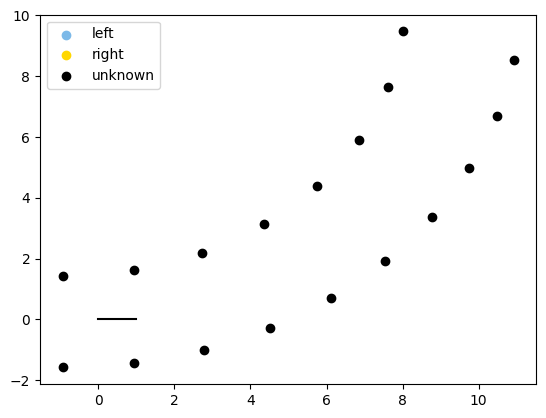

In [84]:
import matplotlib.pyplot as plt

blue_color = "#7CB9E8"
yellow_color = "gold"

plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")
plt.legend()
plt.plot([car_position[0], car_position[0] + car_direction[0]], [car_position[1], car_position[1] + car_direction[1]], c="k")

In [85]:
from fsd_path_planning import PathPlanner, MissionTypes

In [86]:
planner = PathPlanner(MissionTypes.trackdrive)

In [87]:
from fsd_path_planning.utils.utils import Timer

cones_by_type = [np.zeros((0, 2)) for _ in range(5)]
cones_by_type[ConeTypes.LEFT] = cones_left
cones_by_type[ConeTypes.RIGHT] = cones_right
cones_by_type[ConeTypes.UNKNOWN] = cones_unknown


# with Timer("Full Pipeline"):
path = planner.calculate_path_in_global_frame(cones_by_type, car_position, car_direction)
# %timeit planner.calculate_path_in_global_frame(cones_by_type, car_position, car_direction)

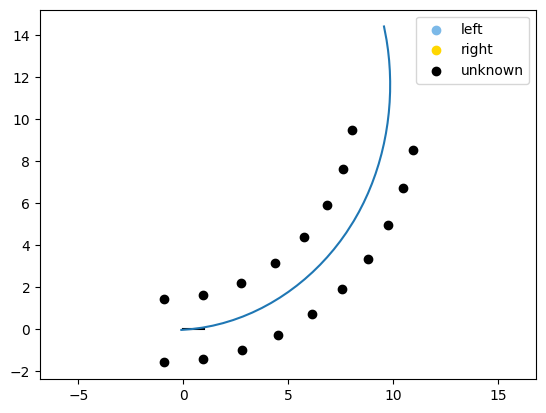

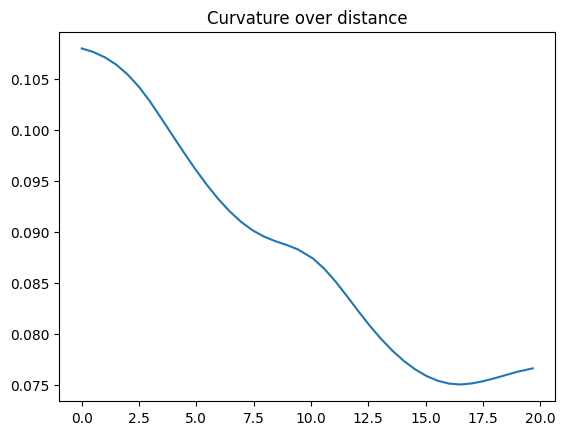

In [89]:
plt.scatter(cones_left[:, 0], cones_left[:, 1], c=blue_color, label="left")
plt.scatter(cones_right[:, 0], cones_right[:, 1], c=yellow_color, label="right")
plt.scatter(cones_unknown[:, 0], cones_unknown[:, 1], c="k", label="unknown")

plt.legend()

plt.plot([car_position[0], car_position[0] + car_direction[0]], [car_position[1], car_position[1] + car_direction[1]], c="k")

plt.plot(*path[:,1:3].T)

plt.axis("equal")

plt.show()

plt.title('Curvature over distance')
plt.plot(path[:, 0], path[:, 3]);